In this notebook, we will see a very simple demonstration of using the MODFLOW-6 API capability for, you guessed, the Freyberg model...

First import as usual...

In [1]:
import os
import shutil
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import modflowapi


We can use pre-compiled mf6 binaries

In [2]:
if "linux" in platform.platform().lower():
    lib_path = os.path.join("bin","linux","libmf6.so")
    exe_path = os.path.join("bin","linux","mf6")
elif "darwin" in platform.platform().lower() or "macos" in platform.platform().lower() :
    lib_path = os.path.join("bin","mac","libmf6.so")
    exe_path = os.path.join("bin","mac","mf6")
else:
    lib_path = os.path.join("bin","win","libmf6.dll")
    exe_path = os.path.join("bin","win","mf6.exe")     



Copy the original model files to a working dir and get the binaries into that dir

In [3]:
org_dir = "monthly_model_files_org"
work_dir = "temp"
if os.path.exists(work_dir):
    shutil.rmtree(work_dir)
shutil.copytree(org_dir,work_dir)
shutil.copy2(lib_path,os.path.join(work_dir,os.path.split(lib_path)[-1]))
shutil.copy2(exe_path,os.path.join(work_dir,os.path.split(exe_path)[-1]))
lib_name = os.path.split(lib_path)[-1]
exe_name = os.path.split(exe_path)[-1]

Now just run standard mf6

In [4]:
c_d = os.getcwd()
os.chdir(work_dir)
os.system("mf6")
os.chdir(c_d)

                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 07/30/2021
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Dec 29 2021 09:30:50 with Intel(R) Fortran Intel(R) 64
   Compiler for applications running on Intel(R) 64, Version 19.1.3.301 Build
                                20200925_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the autho

Now lets see how the API is used - first just replicate the standard MF6 solution

In [5]:
api_dir1 = "api1"
if os.path.exists(api_dir1):
    shutil.rmtree(api_dir1)
shutil.copytree(org_dir,api_dir1)
shutil.copy2(lib_path,os.path.join(api_dir1,os.path.split(lib_path)[-1]))
shutil.copy2(exe_path,os.path.join(api_dir1,os.path.split(exe_path)[-1]))

'api1/mf6'

Create a `ModflowApi` instance for our model and initialize it

In [6]:
gwf = modflowapi.ModflowApi(os.path.join(api_dir1, lib_name), working_directory=api_dir1)
gwf.initialize()

Now march thru the stress periods and solve as usual...

In [7]:
# get current sim time
ctime = gwf.get_current_time()
# get ending sim time
etime = gwf.get_end_time()
# max number of iterations
max_iter = gwf.get_value(gwf.get_var_address("MXITER", "SLN_1"))
# let's do it!
while ctime < etime:
    # the length of this sim time
    dt = gwf.get_time_step()
    # prep the current time step
    gwf.prepare_time_step(dt)
    kiter = 0
    # prep to solve
    gwf.prepare_solve(1)
    # the current one-based stress period number
    stress_period = gwf.get_value(gwf.get_var_address("KPER", "TDIS"))[0]
    time_step = gwf.get_value(gwf.get_var_address("KSTP", "TDIS"))[0]
    # solve until converged
    while kiter < max_iter:
        if gwf.solve(1):
            print("flow stress period,time step {0},{1} converged with {2} iters".\
                  format(stress_period, time_step, kiter))
            break

        kiter += 1
    try:
        gwf.finalize_solve(1)
    except:
        pass

    gwf.finalize_time_step()
    # update current sim time
    ctime = gwf.get_current_time()
gwf.finalize()

flow stress period,time step 1,1 converged with 5 iters
flow stress period,time step 2,1 converged with 1 iters
flow stress period,time step 3,1 converged with 1 iters
flow stress period,time step 4,1 converged with 1 iters
flow stress period,time step 5,1 converged with 1 iters
flow stress period,time step 6,1 converged with 1 iters
flow stress period,time step 7,1 converged with 1 iters
flow stress period,time step 8,1 converged with 1 iters
flow stress period,time step 9,1 converged with 1 iters
flow stress period,time step 10,1 converged with 1 iters
flow stress period,time step 11,1 converged with 1 iters
flow stress period,time step 12,1 converged with 1 iters
flow stress period,time step 13,1 converged with 1 iters
flow stress period,time step 14,1 converged with 1 iters
flow stress period,time step 15,1 converged with 1 iters
flow stress period,time step 16,1 converged with 1 iters
flow stress period,time step 17,1 converged with 1 iters
flow stress period,time step 18,1 conver

Now let's do something more exciting.  We can use the API interface to build in operational rules for the pumping wells.  If the sfr downstream flow for the terminal reach is too low, we need to pump less, if the flow is high, we can pump more.

In [8]:
api_dir2 = "api2"
if os.path.exists(api_dir2):
    shutil.rmtree(api_dir2)
shutil.copytree(org_dir,api_dir2)
shutil.copy2(lib_path,os.path.join(api_dir2,os.path.split(lib_path)[-1]))
shutil.copy2(exe_path,os.path.join(api_dir2,os.path.split(exe_path)[-1]))

'api2/mf6'

In [9]:
gwf = modflowapi.ModflowApi(os.path.join(api_dir2, lib_name), working_directory=api_dir2)
gwf.initialize()

Now we use march thru stess periods as before, but within the outer iteration loop, we will attempt some "management" to link the groundwater extraction rates to surface-water flow.  If the surface-water flow at the terminal downstream reach is less than 2,500, reduce the pumping rates.  Otherwise, if the surface-water flow is greater than 3,000, lets pump more!

In [10]:
# get current sim time
ctime = gwf.get_current_time()
# get ending sim time
etime = gwf.get_end_time()
# max number of iterations
max_iter = gwf.get_value(gwf.get_var_address("MXITER", "SLN_1"))
# let's do it!
while ctime < etime:
    # the length of this sim time
    dt = gwf.get_time_step()
    # prep the current time step
    gwf.prepare_time_step(dt)
    kiter = 0
    # prep to solve
    gwf.prepare_solve(1)
    # the current one-based stress period number
    stress_period = gwf.get_value(gwf.get_var_address("KPER", "TDIS"))[0]
    time_step = gwf.get_value(gwf.get_var_address("KSTP", "TDIS"))[0]
    # solve until converged
    while kiter < max_iter:
        
        # if we have solved at least once and the solution is converged
        if gwf.solve(1) and kiter > 1:
            # get the sfr dsflow rate for the last reach
            addr = ["DSFLOW", "FREYBERG6", "SFR_1"]
            wbaddr = gwf.get_var_address(*addr)
            sfr_dsflow = gwf.get_value(wbaddr)
            print("flow stress period,time step {0},{1} converged with {2} iters, final sfr:{3:5.2f}".\
                  format(stress_period,time_step, kiter,sfr_dsflow[-1]))
            break
        
        # get the sfr dsflow rate for the last reach
        addr = ["DSFLOW", "FREYBERG6", "SFR_1"]
        wbaddr = gwf.get_var_address(*addr)
        sfr_dsflow = gwf.get_value(wbaddr)
        
        #get the wel extraction rates
        "FREYBERG6/WEL-1                   BOUND"
        addr = ["BOUND", "FREYBERG6", "WEl-1"]
        wbaddr = gwf.get_var_address(*addr)
        wel_bound = gwf.get_value_ptr(wbaddr)
        org = np.sum(wel_bound)
        
        # if the flow is too low, turn down the wells
        if sfr_dsflow[-1] < 2500:
            wel_bound[:] *= 0.8
        
        #otherewise if there is extra flow, turn up the wells
        elif sfr_dsflow[-1] > 3000:
            wel_bound[:] *= 1.5
        
        print("  ---  iter:{0}, sfr:{1:5.2f} org wel:{2:5.2f} new wel:{3:5.2f}".\
              format(kiter,sfr_dsflow[-1],org,np.sum(wel_bound)))
        kiter += 1
    try:
        gwf.finalize_solve(1)
    except:
        pass
    
    
    gwf.finalize_time_step()
    # update current sim time
    ctime = gwf.get_current_time()
  

  ---  iter:0, sfr:3907.46 org wel:-900.00 new wel:-1350.00
  ---  iter:1, sfr:3790.98 org wel:-1350.00 new wel:-2025.00
  ---  iter:2, sfr:2109.96 org wel:-2025.00 new wel:-1620.00
  ---  iter:3, sfr:1484.91 org wel:-1620.00 new wel:-1296.00
  ---  iter:4, sfr:1646.62 org wel:-1296.00 new wel:-1036.80
  ---  iter:5, sfr:1668.47 org wel:-1036.80 new wel:-829.44
  ---  iter:6, sfr:1692.51 org wel:-829.44 new wel:-663.55
  ---  iter:7, sfr:2227.05 org wel:-663.55 new wel:-530.84
  ---  iter:8, sfr:2420.25 org wel:-530.84 new wel:-424.67
  ---  iter:9, sfr:2538.17 org wel:-424.67 new wel:-424.67
flow stress period,time step 1,1 converged with 10 iters, final sfr:2618.07
  ---  iter:0, sfr:2623.63 org wel:-900.05 new wel:-900.05
  ---  iter:1, sfr:2865.15 org wel:-900.05 new wel:-900.05
flow stress period,time step 2,1 converged with 2 iters, final sfr:2873.98
  ---  iter:0, sfr:2874.13 org wel:-900.53 new wel:-900.53
  ---  iter:1, sfr:3353.53 org wel:-900.53 new wel:-1350.80
  ---  iter:

  ---  iter:8, sfr:1608.99 org wel:-8209.16 new wel:-6567.33
  ---  iter:9, sfr:1909.70 org wel:-6567.33 new wel:-5253.86
  ---  iter:10, sfr:2257.58 org wel:-5253.86 new wel:-4203.09
  ---  iter:11, sfr:2557.19 org wel:-4203.09 new wel:-4203.09
  ---  iter:12, sfr:2801.31 org wel:-4203.09 new wel:-4203.09
flow stress period,time step 18,1 converged with 13 iters, final sfr:2851.16
  ---  iter:0, sfr:2855.92 org wel:-900.36 new wel:-900.36
  ---  iter:1, sfr:3239.78 org wel:-900.36 new wel:-1350.53
  ---  iter:2, sfr:3251.35 org wel:-1350.53 new wel:-2025.80
  ---  iter:3, sfr:3238.10 org wel:-2025.80 new wel:-3038.70
  ---  iter:4, sfr:3222.67 org wel:-3038.70 new wel:-4558.05
  ---  iter:5, sfr:2826.33 org wel:-4558.05 new wel:-4558.05
  ---  iter:6, sfr:2496.27 org wel:-4558.05 new wel:-3646.44
  ---  iter:7, sfr:2470.29 org wel:-3646.44 new wel:-2917.15
  ---  iter:8, sfr:2623.69 org wel:-2917.15 new wel:-2917.15
  ---  iter:9, sfr:2779.61 org wel:-2917.15 new wel:-2917.15
flow str

Woah - that drastically increased the number of iterations - we are working the solver here with some strong nonlinearity!

In [11]:
lst_org = flopy.utils.Mf6ListBudget(os.path.join(work_dir,"freyberg6.lst"))
lst_api = flopy.utils.Mf6ListBudget(os.path.join(api_dir2,"freyberg6.lst"))

In [12]:
oinc,ocum = lst_org.get_dataframes(diff=True)
ainc,acum = lst_api.get_dataframes(diff=True)


Text(0.5, 1.0, 'sw-gw flux')

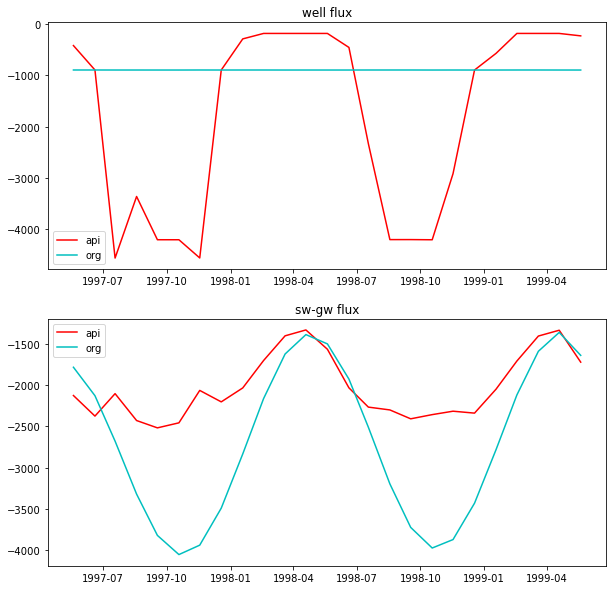

In [13]:
fig,axes = plt.subplots(2,1,figsize=(10,10))
axes[0].plot(ainc.index,ainc.wel,color="r",label="api")
axes[0].plot(oinc.index,oinc.wel,color="c",label="org")
axes[1].plot(ainc.index,ainc.sfr,color="r",label="api")
axes[1].plot(oinc.index,oinc.sfr,color="c",label="org")
axes[0].legend()
axes[0].set_title("well flux")
axes[1].legend()
axes[1].set_title("sw-gw flux")


We can see the effect of our "management" strategy:  substantially more gw is extracted during the wet season while less groundwater is extracted during the dry season compared to the original simulation (that used constant extraction).  And we see that this contributes to less groundwater contribution to surface water during the wet season.